### Dataset
https://www.kaggle.com/c/avazu-ctr-prediction

In [91]:
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import graphviz 
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [4]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [7]:
dfs = pd.read_csv('data/train_sample_smaller.csv')

Show first rows of dataframe

In [8]:
dfs.head()

,Unnamed: 0,Unnamed: 0.1,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,5652132,10055248,1.490366e+19,0,14102304,1005,0,41477778,4b23d058,f028772b,...,1,0,20363,216,36,2333,0,39,-1,157
1,3160240,19172261,1.176958e+19,1,14102517,1005,1,e151e245,7e091613,f028772b,...,1,0,20394,320,50,2340,3,1065,100111,159
2,474016,21893485,6.379721e+18,0,14102611,1005,0,85f751fd,c4e18dd6,50e219e0,...,1,0,22587,320,50,2606,3,33,100004,61
3,205776,21796118,1.622506e+19,0,14102611,1005,1,85f751fd,c4e18dd6,50e219e0,...,1,0,22558,300,50,1863,3,39,-1,23
4,6797482,14086459,1.002854e+19,0,14102406,1005,1,d9750ee7,98572c79,f028772b,...,1,0,17614,320,50,1993,2,1063,-1,33


In [9]:
dfs.nunique()

Unnamed: 0          808579
Unnamed: 0.1        808579
id                  808579
click                    2
hour                   240
C1                       7
banner_pos               7
site_id               2542
site_domain           2684
site_category           22
app_id                2955
app_domain             203
app_category            28
device_id           123749
device_ip           466791
device_model          4980
device_type              4
device_conn_type         4
C14                   2220
C15                      8
C16                      9
C17                    422
C18                      4
C19                     66
C20                    163
C21                     60
dtype: int64

In [20]:
f_categorical = ['device_conn_type', 'app_category', 'site_category', 'app_domain', 'device_type', 'banner_pos']
f_numeric = ['hour']
target = 'click'

Select numeric datafields for X, but not the last three columns.
Select 'count' for y.

In [21]:
X = dfs[f_numeric + f_categorical]
y = dfs[target]

### define some custom classes to be used with sklearn

In [22]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, x, y):
        return self
    
    def transform(self, x):
        return x[self.columns]

In [23]:
class CatToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapping = {}
        
    def fit(self, x, y):
        for col in x.columns:
            self.mapping[col] = {key: idx + 1 for idx, key in enumerate(x[col].unique())}
        return self
    
    def col_lookup(self, col):
        def lookup(val):
            return self.mapping[col].get(val, 0)
        return lookup
    
    def transform(self, x):
        output = []
        for col in x.columns:
            output.append(x[col].apply(self.col_lookup(col)))
        return pd.concat(output, axis=1)

### Build a sklearn pipeline

In [59]:
pipe_numeric = make_pipeline(
    ColumnSelector(f_numeric)
)

pipe_categorical = make_pipeline(
    ColumnSelector(f_categorical),
    CatToNumeric(),
    #OneHotEncoder(sparse=False)
)

est = make_pipeline(
    make_union(pipe_numeric, pipe_categorical),
    RandomForestClassifier(max_depth=10)
)

### create test and training set.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### check the output of the categorical pipe

In [29]:
est = est.fit(X_train, y_train)

### Predict the training set.

In [37]:
y_train_pred = est.predict_proba(X_train)

### Predict the test set.

In [38]:
y_test_pred = est.predict_proba(X_test)

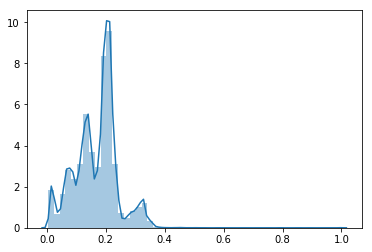

In [71]:
sns.distplot(y_test_pred[:, 1])

In [92]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [95]:
def select_threshold_and_plot(threshold):
    y_test_pred_class = pd.Series(0, index=X_test.index)
    y_test_pred_class[y_test_pred[:, 1] > threshold] = 1

    cnf_matrix = confusion_matrix(y_test, y_test_pred_class)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Not-Converted', 'Converted'],
                          title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[134266     14]
 [ 27379     57]]


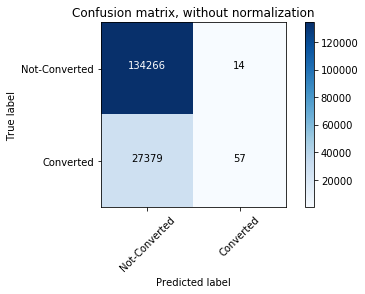

In [96]:
select_threshold_and_plot(0.5)

Confusion matrix, without normalization
[[128388   5892]
 [ 24454   2982]]


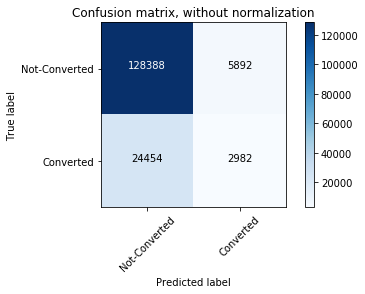

In [100]:
select_threshold_and_plot(0.3)

Confusion matrix, without normalization
[[ 27572 106708]
 [  1563  25873]]


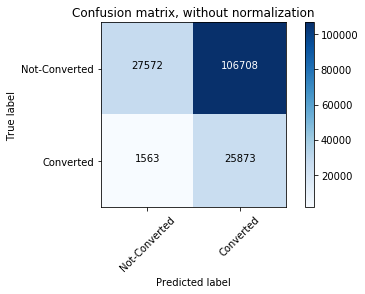

In [99]:
select_threshold_and_plot(0.1)

In [94]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred[:, 1])

No handles with labels found to put in legend.


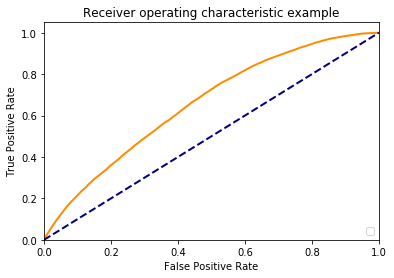

In [69]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Calculate the roc auc score for the training set.

In [41]:
roc_auc_score(y_train, y_train_pred[:, 1])

0.6647301522295438

### Calculate the roc auc score for the test set.

In [42]:
roc_auc_score(y_test, y_test_pred[:, 1])

0.6570487143790387

### Cross Validation

In [43]:
scores = cross_val_score(est, X_train, y_train, cv=5, scoring='roc_auc')

In [65]:
scores

array([0.65988545, 0.65937894, 0.65708048, 0.65756399, 0.65542043])

In [63]:
scores.mean()

0.6578658590791691

In [64]:
scores.std()

0.0016159335906466283

### Grid search

In [44]:
est.get_params()

{'featureunion': FeatureUnion(n_jobs=1,
        transformer_list=[('pipeline-1', Pipeline(memory=None,
      steps=[('columnselector', ColumnSelector(columns=['hour']))])), ('pipeline-2', Pipeline(memory=None,
      steps=[('columnselector', ColumnSelector(columns=['device_conn_type', 'app_category', 'site_category', 'app_domain', 'device_type', 'banner_pos'])), ('cattonumeric', CatToNumeric())]))],
        transformer_weights=None),
 'featureunion__n_jobs': 1,
 'featureunion__pipeline-1': Pipeline(memory=None,
      steps=[('columnselector', ColumnSelector(columns=['hour']))]),
 'featureunion__pipeline-1__columnselector': ColumnSelector(columns=['hour']),
 'featureunion__pipeline-1__columnselector__columns': ['hour'],
 'featureunion__pipeline-1__memory': None,
 'featureunion__pipeline-1__steps': [('columnselector',
   ColumnSelector(columns=['hour']))],
 'featureunion__pipeline-2': Pipeline(memory=None,
      steps=[('columnselector', ColumnSelector(columns=['device_conn_type', 'app_c

In [45]:
param_grid = {
    'randomforestclassifier__max_depth': [10, 20],    
    'randomforestclassifier__n_estimators': [1, 10, 50]
}

In [51]:
grid_search = GridSearchCV(est, param_grid, scoring='roc_auc', n_jobs=4, cv=3)

In [52]:
grid_search = grid_search.fit(X_train, y_train)

In [53]:
res_df = pd.DataFrame(grid_search.cv_results_)
res_df

/Users/levin/projects/python-data-science/.venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/levin/projects/python-data-science/.venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/levin/projects/python-data-science/.venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.537813,1.032842,0.640378,0.647133,10,1,"{'randomforestclassifier__max_depth': 10, 'ran...",6,0.641939,0.647140,0.640303,0.644509,0.638892,0.649750,0.049835,0.004194,0.001245,0.002140
1,5.214808,1.342306,0.657098,0.666387,10,10,"{'randomforestclassifier__max_depth': 10, 'ran...",2,0.659454,0.667022,0.657516,0.664457,0.654324,0.667683,0.074789,0.027627,0.002115,0.001392
2,18.818669,2.335467,0.658755,0.667831,10,50,"{'randomforestclassifier__max_depth': 10, 'ran...",1,0.660793,0.667570,0.659901,0.666699,0.655570,0.669223,0.136185,0.113180,0.002281,0.001046
3,2.681221,1.125784,0.642901,0.679706,20,1,"{'randomforestclassifier__max_depth': 20, 'ran...",5,0.642646,0.680819,0.644166,0.677573,0.641892,0.680726,0.070350,0.098252,0.000946,0.001509
4,8.141990,1.581284,0.651599,0.699881,20,10,"{'randomforestclassifier__max_depth': 20, 'ran...",4,0.651714,0.699665,0.653005,0.699413,0.650079,0.700565,0.189691,0.078129,0.001198,0.000495
5,27.605438,3.561227,0.652730,0.702241,20,50,"{'randomforestclassifier__max_depth': 20, 'ran...",3,0.652707,0.702052,0.654395,0.701897,0.651087,0.702775,0.364642,0.139676,0.001351,0.000383


In [54]:
label = ("depth: " + res_df['param_randomforestclassifier__max_depth'].astype(str) +
    " n_est: " + res_df['param_randomforestclassifier__n_estimators'].astype(str))

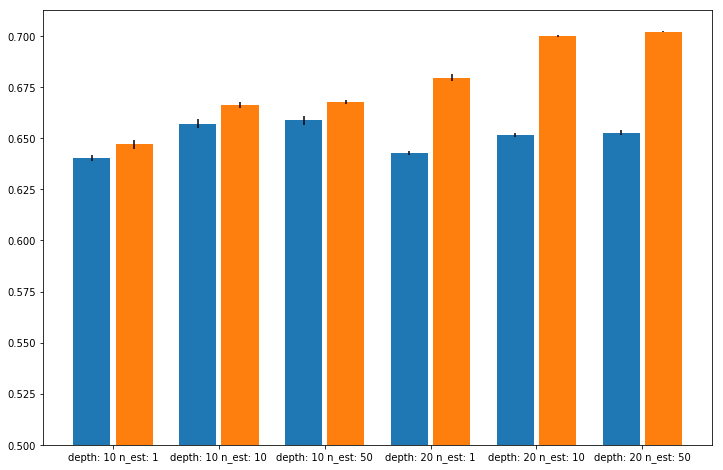

In [58]:
plt.figure(figsize=[12, 8])
plt.bar(res_df.index - 0.2, res_df['mean_test_score'] - 0.5, bottom=0.5, width = 0.35, yerr=res_df['std_test_score'])
plt.bar(res_df.index + 0.2, res_df['mean_train_score'] - 0.5, bottom=0.5, width = 0.35, yerr=res_df['std_train_score'])
plt.xticks(res_df.index, label)
plt.show()